In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

#my functions
from Contours import FindContour
from Mask import segment_image
from Plot import plot_cv, plot_img

In [2]:
path = '../../Data/clock3.jpg'
img = cv.imread(path, cv.IMREAD_COLOR_RGB)
img.shape

(626, 626, 3)

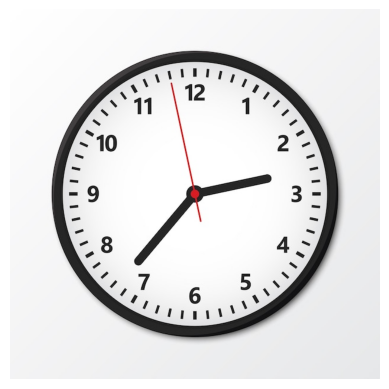

In [3]:
plot_img(img, gray = False)

In [4]:
def channels(img):
    Xred = img[:, :, 0]
    Xgreen = img[:, :, 1]
    Xblue = img[:, :, 2]
    return Xred, Xgreen, Xblue

In [5]:
Xred, _, _ = channels(img)

Height: 626, Width: 626
The area of the image in pixels are: 352530


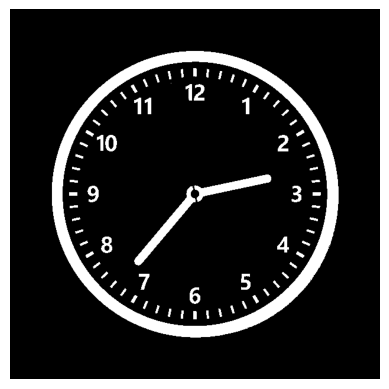

In [6]:
thres = 120
thres_img = segment_image(Xred, thres)
thres_img = cv.bitwise_not(thres_img)
plot_img(thres_img)

In [7]:
def get_center(img):
    xs, ys = [], []
    M, N = img.shape

    for i in range(M):
        for j in range(N):
            if img[i, j] != 0:
                xs.append(i)
                ys.append(j) 
    return xs, ys

In [8]:
xs, ys = get_center(Xred)
center_x = int(np.mean(xs))
center_y = int(np.mean(ys))
center_x, center_y

(312, 312)

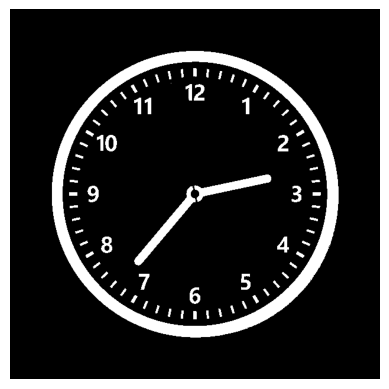

In [9]:
plot_img(thres_img)

contours, _ = cv.findContours(thres_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

circled = img.copy()

cv.drawContours(circled, contours, -1, (0, 255, 0), 3)

plt.imshow(circled)
plt.show()

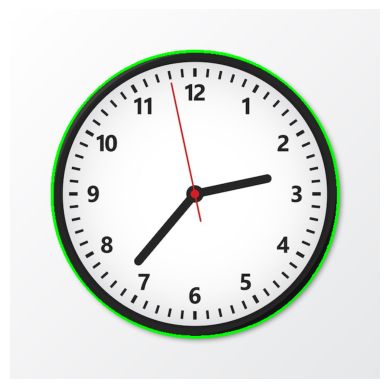

In [10]:
find = FindContour(thres_img)
contour = find.search_contour()
contours = find.contour2CV(contour)

circled = img.copy()
cv.drawContours(circled, contours, -1, (0, 255, 0), 3)

plot_img(circled)

In [11]:
def get_radius(contours, center_x, center_y, point_index):
    if point_index > len(contours[0]):
        raise IndexError("Out limits")
    
    point = contours[0][point_index][0] 
    r = np.sqrt((center_x - point[0])**2 + (center_y - point[1])**2)
    return r, point


In [12]:
r, point = get_radius(contours, center_x, center_y, 0)
r

np.float64(241.40629652103112)

In [13]:
print(center_x-point[0], center_y -point[1])

14 241


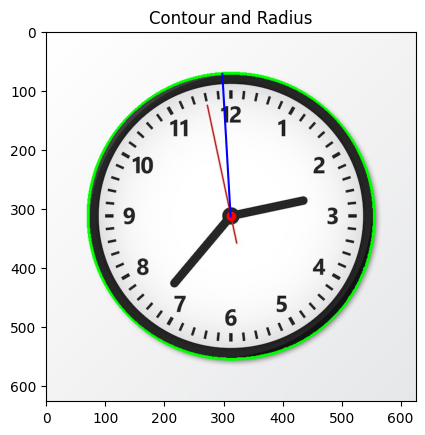

In [14]:
plt.imshow(circled, cmap=plt.cm.gray)
plt.plot(center_x, center_y, 'ro') 

plt.plot([center_x, point[0]], [center_y, point[1]], 'b-') 
plt.title("Contour and Radius")
plt.show()

## First Version to Search the Hands on The Clock

In [15]:
amount_lines = 20

In [16]:
def detect_hands(img_bin, cx, cy, radius, top_k=3):
    h, w = img_bin.shape
    strengths = [] #len and angle

    for angle in range(0, 360, 1): 
        theta = math.radians(angle)
        count = 0

        for r in range(radius):
            x = int(cx + r * math.cos(theta))
            y = int(cy + r * math.sin(theta))

            if 0 <= x < w and 0 <= y < h:
                if img_bin[y, x] == 255:
                    count += 1

        strengths.append((count, angle))

    strengths.sort(reverse=True, key=lambda x: x[0])
    return strengths[:top_k]

In [17]:
def draw_hands(img, cx, cy, hands, r):  
    out = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    for count, angle in hands:
        limited_r = min(r, count)  

        theta = math.radians(angle)
        x_end = int(cx + limited_r * math.cos(theta))
        y_end = int(cy + limited_r * math.sin(theta))

        cv.line(out, (cx, cy), (x_end, y_end), (255, 0, 0), 2)

    return out

In [18]:
hands1 = detect_hands(thres_img, center_x, center_y, int(r), amount_lines)
hands1.sort(key= lambda x: x[1])
hands1

[(104, 125),
 (141, 126),
 (159, 127),
 (164, 128),
 (165, 129),
 (164, 130),
 (165, 131),
 (174, 132),
 (121, 133),
 (94, 134),
 (122, 345),
 (137, 346),
 (140, 347),
 (154, 348),
 (140, 349),
 (140, 350),
 (138, 351),
 (124, 352),
 (99, 353),
 (99, 354)]

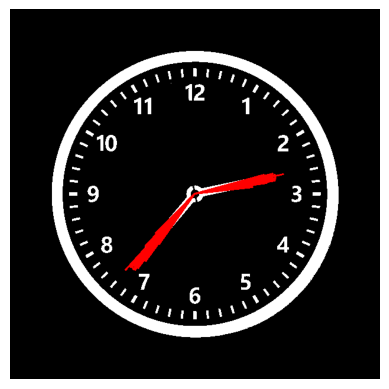

In [19]:
img_hands = draw_hands(thres_img, center_x, center_y, hands1, r)

plot_img(img_hands)

## Second Version to Search the Hands on The Clock

In [20]:
def detect_hands_lengths(img_bin, cx, cy, radius, amount_lines=2, start_skip=5, gap_tol=3):
    h, w = img_bin.shape
    results = []

    for ang in range(0, 360, 1):
        theta = math.radians(ang) #degree to radian
        white = 0 #amount of white pixels
        black = 0 #black pixels
        seen_wht = False 

        for r in range(start_skip, radius):
            x = int(round(cx + r * math.cos(theta)))
            y = int(round(cy + r * math.sin(theta)))
            if not (0 <= x < w and 0 <= y < h):
                break

            if img_bin[y, x] == 255:
                seen_wht = True
                white += 1
                black = 0
            else:
                if seen_wht:
                    black += 1
                    if black >= gap_tol:
                        break
        
        length = white
        results.append((length, ang))

    results.sort(reverse=True, key=lambda t: t[0])
    return results[:amount_lines] #(length, angle)

In [21]:
hands23 = detect_hands_lengths(thres_img, center_x, center_y, int(r), amount_lines)
hands23.sort(key = lambda x: x[1])
for length, ang in hands23:
    print(f"Length in pixels: {length}, Angle: {ang:.1f}°")


Length in pixels: 79, Angle: 125.0°
Length in pixels: 98, Angle: 126.0°
Length in pixels: 132, Angle: 127.0°
Length in pixels: 147, Angle: 128.0°
Length in pixels: 148, Angle: 129.0°
Length in pixels: 148, Angle: 130.0°
Length in pixels: 147, Angle: 131.0°
Length in pixels: 146, Angle: 132.0°
Length in pixels: 115, Angle: 133.0°
Length in pixels: 86, Angle: 134.0°
Length in pixels: 84, Angle: 344.0°
Length in pixels: 115, Angle: 345.0°
Length in pixels: 123, Angle: 346.0°
Length in pixels: 124, Angle: 347.0°
Length in pixels: 125, Angle: 348.0°
Length in pixels: 124, Angle: 349.0°
Length in pixels: 124, Angle: 350.0°
Length in pixels: 122, Angle: 351.0°
Length in pixels: 98, Angle: 352.0°
Length in pixels: 76, Angle: 353.0°


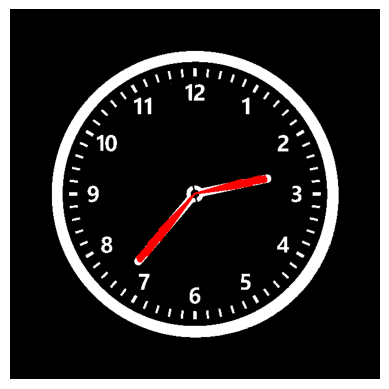

In [22]:
img_hands = draw_hands(thres_img, center_x, center_y, hands23, r)
plot_img(img_hands)

In [23]:
plot_cv(img_hands)

## Cluster The Possible Hands by Angles

¿wrap-around? 
 if len(clusters) > 1:
        first_min_angle = clusters[0][0][1]
        last_max_angle  = clusters[-1][-1][1]
        if (first_min_angle + 360.0 - last_max_angle) <= interval_deg:
            # fusionar: el último va antes del primero
            merged = clusters[-1] + clusters[0]
            clusters = [merged] + clusters[1:-1]

    return clusters

In [24]:
def cluster_by_angle(canditates, interval_deg=10):
    if not canditates:
        return []

    cands = sorted(canditates, key=lambda t: t[1])

    clusters = []
    cur = [cands[0]]
    last_angle = cands[0][1]

    for length, angle in cands[1:]:
        if (angle - last_angle) <= interval_deg:
            cur.append((length, angle))
        else:
            clusters.append(cur)
            cur = [(length, angle)]
        last_angle = angle

    clusters.append(cur)

    return clusters #(length, angle)

In [25]:
clusters = cluster_by_angle(hands23)
clusters

[[(79, 125),
  (98, 126),
  (132, 127),
  (147, 128),
  (148, 129),
  (148, 130),
  (147, 131),
  (146, 132),
  (115, 133),
  (86, 134)],
 [(84, 344),
  (115, 345),
  (123, 346),
  (124, 347),
  (125, 348),
  (124, 349),
  (124, 350),
  (122, 351),
  (98, 352),
  (76, 353)]]

In [26]:
def pick_biggest(cluster):
    #cluster = (length, angle)
    reps = []
    for group in cluster: 
        best = max(group, key = lambda x: x[0]) #pick the length
        angles = [a for _, a in group]
        reps.append({
            "angle": best[1] % 360.0,
            "length": best[0],
            "count": len(group),
            "min_angle": min(angles) % 360.0,
            "max_angle": max(angles) % 360.0,
        })
    return reps

In [27]:
values = pick_biggest(clusters)
values

[{'angle': 129.0,
  'length': 148,
  'count': 10,
  'min_angle': 125.0,
  'max_angle': 134.0},
 {'angle': 348.0,
  'length': 125,
  'count': 10,
  'min_angle': 344.0,
  'max_angle': 353.0}]

In [28]:
def draw_hands_on_image(img, cx, cy, reps, start_skip=5, thickness=3):
    out_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    palette = [(0, 0, 255), (255, 0, 0)] #red and blue

    for i, d in enumerate(reps):
        ang = float(d["angle"])
        L = int(d["length"])
        L_draw = L + int(start_skip)

        theta = math.radians(ang)
        xe = int(round(cx + L_draw * math.cos(theta)))
        ye = int(round(cy + L_draw * math.sin(theta)))

        color = palette[i % len(palette)]
        cv.line(out_img, (int(cx), int(cy)), (xe, ye), color, thickness, cv.LINE_AA)
        cv.circle(out_img, (xe, ye), 4, color, -1, cv.LINE_AA) #end line

    cv.circle(out_img, (int(cx), int(cy)), 8, (255, 255, 255), -1, cv.LINE_AA) #center circle
    return out_img

In [29]:
overlay = draw_hands_on_image(thres_img, center_x, center_y, values)

In [30]:
def get_time(reps):
    if not reps or len(reps) < 2:
        return None, None

    a, b = sorted(reps, key=lambda d: d["length"], reverse=True)
    minute_rep = a["angle"]
    hour_rep = b["angle"]

    phiM = (float(minute_rep) + 90.0) % 360.0
    phiH = (float(hour_rep) + 90.0) % 360.0

    #minutes 
    M = int(round(phiM / 6.0)) % 60

    #hour
    hour_float = ((phiH - 0.5 * M) / 30.0) % 12.0
    H = int(round(hour_float)) % 12
    H = 12 if H == 0 else H

    return H, M

In [31]:
H, M = get_time(values)
print(f"{H:02d}:{M:02d}")

02:36


In [32]:
plot_cv(overlay)